# Modeling Passsing Statistics
***

In [8]:
import pandas as pd
import numpy as np
import importlib
from helpers import passing 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

Description of data columns

In [35]:
passing_data = pd.read_csv('data/nfl_passing_stats.csv')
passing_data.head()

,Player,Year,Wk,Opp,Result,Comp,Att_P,Yds_P,Avg_P,TD_P,Ints,Sck,Scky,Rate,Att_R,Yds_R,Avg_R,TD_R,Fum,Lost
0,Joe Burrow,2024,18,@Steelers,W 19 - 17,37.0,46.0,277.0,6.0,1.0,1.0,4.0,31.0,90.0,1.0,-1.0,-1.0,0.0,1.0,0.0
1,Joe Burrow,2024,17,Broncos,W 30 - 24,39.0,49.0,412.0,8.4,3.0,0.0,7.0,28.0,122.1,4.0,25.0,6.2,1.0,NaN,NaN
2,Joe Burrow,2024,16,Browns,W 24 - 6,23.0,30.0,252.0,8.4,3.0,0.0,4.0,42.0,134.3,2.0,19.0,9.5,0.0,1.0,1.0
3,Joe Burrow,2024,15,@Titans,W 37 - 27,26.0,37.0,271.0,7.3,3.0,2.0,1.0,2.0,95.7,NaN,NaN,NaN,NaN,1.0,1.0
4,Joe Burrow,2024,14,@Cowboys,W 27 - 20,33.0,44.0,369.0,8.4,3.0,1.0,2.0,10.0,112.8,2.0,-2.0,-1.0,0.0,1.0,0.0


In [49]:
importlib.reload(passing)
PLAYER = "Patrick Mahomes"
player_data = passing.clean_nan( passing_data.loc[passing_data['Player'] == PLAYER] )
print("Number of Rows:", len(player_data))

Number of Rows: 51


## Model 1: Predicting Quantity of Passing Yards

In [85]:
importlib.reload(passing)

<module 'helpers.passing' from 'c:\\Users\\cgarv\\risky-griff\\helpers\\passing.py'>

In [86]:
# Set features and statistic to predict
X, y = passing.prep_passing_td(player_data)

# Split player data into training(80%) and testing(20%) subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.head()

,Avg_P,TD_P,Ints,Cmp_rate
8,6.3,1.0,0.0,0.666667
49,6.0,2.0,2.0,0.720000
6,7.3,3.0,0.0,0.729730
47,8.4,1.0,1.0,0.655172
4,5.7,1.0,0.0,0.648649


In [60]:
deg_results = []

for degree in range(6):
    poly_model = PolynomialFeatures(degree=degree)

    X_train_poly = poly_model.fit_transform(X_train)
    X_test_poly = poly_model.transform(X_test)

    tst_model = LinearRegression()
    tst_model.fit(X_train_poly, y_train)
    
    # Compute model stats
    y_hat = tst_model.predict(X_test_poly)
    r_sq = r2_score(y_test, y_hat)
    rmse = np.sqrt(mean_squared_error(y_test, y_hat))

    deg_results.append((degree, r_sq, rmse))

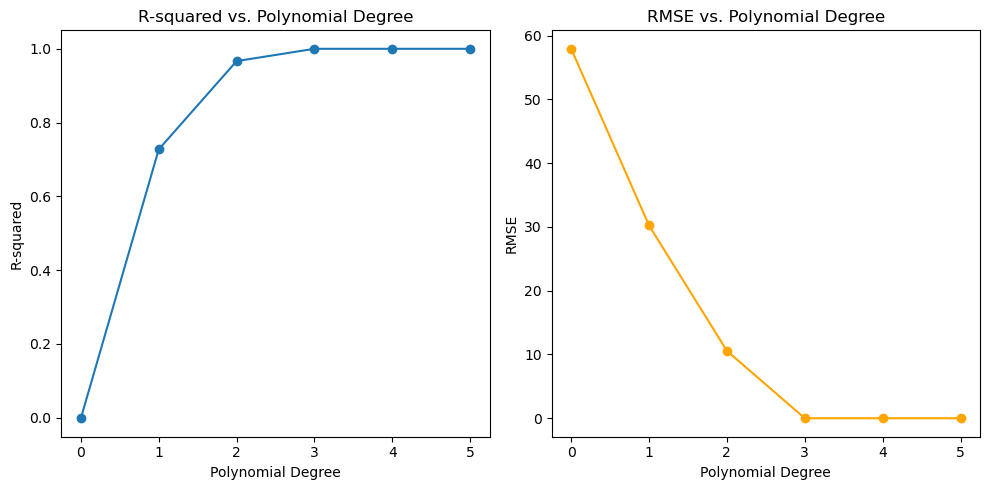

In [61]:
degrees, r2_scores, rmse_scores = zip(*deg_results)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(degrees, r2_scores, marker='o')
plt.xlabel('Polynomial Degree')
plt.ylabel('R-squared')
plt.title('R-squared vs. Polynomial Degree')

plt.subplot(1, 2, 2)
plt.plot(degrees, rmse_scores, marker='o', color='orange')
plt.xlabel('Polynomial Degree')
plt.ylabel('RMSE')
plt.title('RMSE vs. Polynomial Degree')

plt.tight_layout()
plt.show()

In [87]:
poly_model = PolynomialFeatures(degree=2)
X_train_poly = poly_model.fit_transform(X_train)
X_test_poly = poly_model.transform(X_test)

pm1 = LinearRegression()
pm1.fit(X_train_poly, y_train)

tst_pred = pm1.predict(X_test_poly)
r2 = r2_score(y_test, tst_pred)
rmse = np.sqrt(mean_squared_error(y_test, tst_pred))
print(f"  R-squared: {r2}")
print(f"  RMSE: {rmse}")

  R-squared: 0.9666829657420634
  RMSE: 10.569266770531026


Text(0, 0.5, 'Predicted Passing Yds')

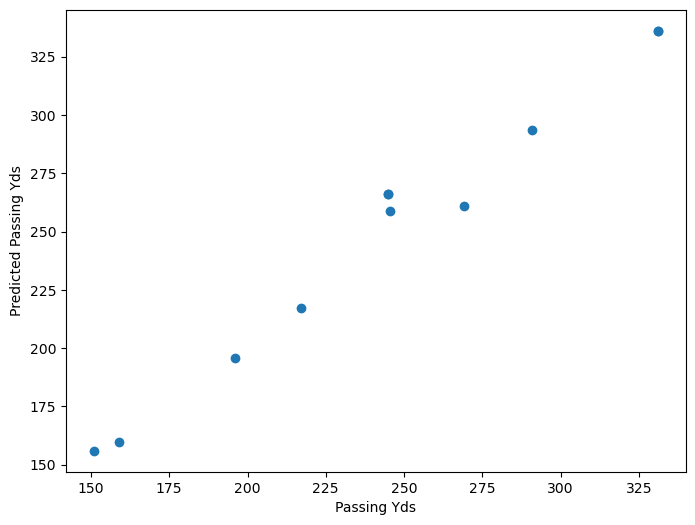

In [88]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, tst_pred)
plt.xlabel("Passing Yds")
plt.ylabel("Predicted Passing Yds")

## Predicting
<!-- 
The below cell is a reference to the current players average stats which can be used as a guide for the input to the following cell.  Add in your guess respectively for the players average passing yards, passing touchdowns, thrown interceptions, and pass completion rate (as a proportion) into the numpy `predictions` array. -->
### On a scale of 1 - 10, how well do you think selected player will play?
Enter the value below:

In [174]:
# YOUR GUESS HERE
player_performance = 10

Sample statistics are generated using the value entered for the `player_performance` variable.  These statistics are then used in the model to calculate the predicted passing yards. 

In [241]:
predictions = np.array([passing.sample_stats(player_performance, X)])
print("Sampled Player Stats:", predictions)

poly_pred = poly_model.fit_transform(predictions)
y_hat = pm1.predict(poly_pred)
print("Predicted Passing Yards:", y_hat[0]) 

Sampled Player Stats: [[5.49651206e+00 6.76302864e-01 7.36254778e-04 6.11329987e-01]]
Predicted Passing Yards: 237.3370335966756
